In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from matplotlib import pyplot as plt
import selfies as sf
import mutations as mut
from functools import partial
import metrics as met
import functions as fn
from constants import *
from rdkit import Chem
from rdkit.Chem import Draw
import seaborn as sns
import pandas as pd
from datetime import datetime

c:\Users\marti\anaconda3\envs\thesis_3.8\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
SEED_SIZE_LIST = [10, 100, 1000, 10000, 100000]
SEED_SIZE = SEED_SIZE_LIST[3] #10^1, 10^2, ... 10^5
SEED_LIST = [0,1,2]
SEED = SEED_LIST[2] #0 or 1 or 2
BUDGET_LIST = [100, 1000, 10000, 100000]
BUDGET = BUDGET_LIST[2]
GENERATIONS = 10
N = BUDGET / GENERATIONS

SEED_PATH = f"../data/seed_{SEED}/rand_{SEED_SIZE}.tsv"

In [4]:
seed_df = pd.read_table(SEED_PATH) 
seed_df

,smiles
0,CCOC1CC2CC(C3CCCCC3)OC2O1
1,CCOC(=O)COn1c(=O)c(-c2ccc(OC)c(OC)c2)[n+]([O-]...
2,CCCc1c(O)n(Cc2ccc(F)cc2)c2nc3c(n2c1=O)C(=O)N(C...
3,O=C(O)CCNC(=O)c1nc(-c2ccnnc2)c2c(cc(-c3ccccc3)...
4,COCCOC(=O)c1[nH]c2c(c1C)C(=O)CC(c1ccc(OC)cc1)C2
...,...
9995,CCOC(=O)C1(c2ccccc2)CCCNC1=O
9996,CCOc1ccc2[nH]c3c(N4CCc5ccccc5C4)ncnc3c2c1
9997,O=C(NS(=O)(=O)N1CCC1)c1cc(C2CC2)c(OC2CC3CCC2C3...
9998,C[N+](C)(CCCCCCCCCCCS)Cc1ccccc1


In [5]:
metric_function_list = [
    partial(met.get_obj,objective="zale")
]
metrics = ['Metric 1']

In [6]:
metric_function_list

[functools.partial(<function get_obj at 0x00000194EBB36310>, objective='zale')]

In [7]:
initial_pop = fn.convert_seeds_to_df(seed_df,metric_function_list)
initial_pop

100%|██████████| 10000/10000 [00:24<00:00, 412.54it/s]


,SMILES molecule,Generation,Metric 1
0,CCOC1CC2CC(C3CCCCC3)OC2O1,0,2.454227e-03
1,CCOC(=O)COn1c(=O)c(-c2ccc(OC)c(OC)c2)[n+]([O-]...,0,3.457247e-02
2,CCCc1c(O)n(Cc2ccc(F)cc2)c2nc3c(n2c1=O)C(=O)N(C...,0,2.361386e-02
3,O=C(O)CCNC(=O)c1nc(-c2ccnnc2)c2c(cc(-c3ccccc3)...,0,1.017287e-06
4,COCCOC(=O)c1[nH]c2c(c1C)C(=O)CC(c1ccc(OC)cc1)C2,0,1.428479e-02
...,...,...,...
9995,CCOC(=O)C1(c2ccccc2)CCCNC1=O,0,5.690963e-02
9996,CCOc1ccc2[nH]c3c(N4CCc5ccccc5C4)ncnc3c2c1,0,1.558571e-01
9997,O=C(NS(=O)(=O)N1CCC1)c1cc(C2CC2)c(OC2CC3CCC2C3...,0,1.440949e-03
9998,C[N+](C)(CCCCCCCCCCCS)Cc1ccccc1,0,8.017240e-11


In [8]:
mutation_function_list = [
    partial(mut.replacement)
    ,partial(mut.addition,fragment_size=1)
    ,partial(mut.deletion,n=1)
]

In [9]:
current_dateTime = datetime.now()

time_format = f"{current_dateTime.date()}_{str(current_dateTime.hour).zfill(2)}-{str(current_dateTime.minute).zfill(2)}-{str(current_dateTime.second).zfill(2)}"
print(time_format)
save = False


2023-06-11_16-11-26
NOT SAVED


In [41]:
n = 80
if len(initial_pop)>=n:
    initial_best = initial_pop.sort_values(metrics,ascending=False).head(n)
else:
    initial_best = initial_pop


#initial_best = fn.get_percent_best(initial_pop, metrics,0.5,minimize=False)
initial_best.head()

,SMILES molecule,Generation,Metric 1
5875,Cc1nn(Cc2c(Cl)cccc2C#N)c2cc(CCC(=O)O)ccc12,0,0.508453
8836,COc1ccccc1-c1ccc(C(=O)Nc2cccc(C)n2)nc1,0,0.502331
3162,COc1cccc(C(C)NC(=O)c2cnc(-c3ccncc3)s2)c1,0,0.499907
8484,CCOC(=O)CC(=O)CSc1nc(C)cc(-c2cccnc2)c1C#N,0,0.477648
2184,CN(C)c1cccc(-c2cccc(C(=O)c3ccc(F)c(O)c3)n2)c1,0,0.477648


In [42]:
gen_history = pd.DataFrame(columns=initial_best.columns)
print(gen_history.columns)

generations = 10

budget = n * generations

#budget_allocation = fn.distribute_budget(budget,generations)
budget_allocation = [n]*generations
print(budget,budget_allocation)

temp_best = initial_best.copy(deep=True)
for generation in (range(len(budget_allocation))): 
    temp_pop = fn.populate_from_df_batch(temp_best,budget_allocation[generation],metric_function_list,mutation_function_list,
                                   generation,include_seeds=True,fitness='Metric 1')
    temp_pop.reset_index(drop=True,inplace=True)

    temp_best =fn.get_percent_best(temp_pop, metrics,0.5,minimize=False)
    gen_history = pd.concat([gen_history,temp_best])

Index(['SMILES molecule', 'Generation', 'Metric 1'], dtype='object')
800 [80, 80, 80, 80, 80, 80, 80, 80, 80, 80]
before 80
after 80


100%|██████████| 80/80 [00:00<00:00, 467.84it/s]


before 40
after 100


100%|██████████| 100/100 [00:00<00:00, 502.51it/s]


before 50
after 95


100%|██████████| 95/95 [00:00<00:00, 497.38it/s]


before 47
after 96


100%|██████████| 96/96 [00:00<00:00, 500.00it/s]


before 48
after 96


100%|██████████| 96/96 [00:00<00:00, 492.31it/s]


before 48
after 96


100%|██████████| 96/96 [00:00<00:00, 492.31it/s]


before 48
after 96


100%|██████████| 96/96 [00:00<00:00, 489.79it/s]


before 48
after 96


100%|██████████| 96/96 [00:00<00:00, 489.80it/s]


before 48
after 96


100%|██████████| 96/96 [00:00<00:00, 489.80it/s]


before 48
after 96


100%|██████████| 96/96 [00:00<00:00, 494.85it/s]


In [43]:
latest_gen = gen_history[gen_history['Generation']==gen_history['Generation'].max()]
latest_gen.head()

,SMILES molecule,Generation,Metric 1
48,CC1=NN(CC2=C(Cl)C=CC=C2C#N)C3=CC(CCC(=O)O)=CC=C13,9,0.508453
49,CC1=NN(CC2=C(Cl)C=CC=C2C#N)C3=CC(CCC(=O)O)=CC=C13,9,0.508453
50,COC1=CC=CC=C1C2=CC=C(C(=O)NC3=CC=CC(C)=N3)N=C2,9,0.502331
51,COC1=CC=CC(C(C)NC(=O)C2=CN=C(C3=CC=NC=C3)S2)=C1,9,0.499907
52,CN(C)C1=CC=CC(C2=CC=CC(C(=O)C3=CC=C(F)C(O)=C3)...,9,0.477648


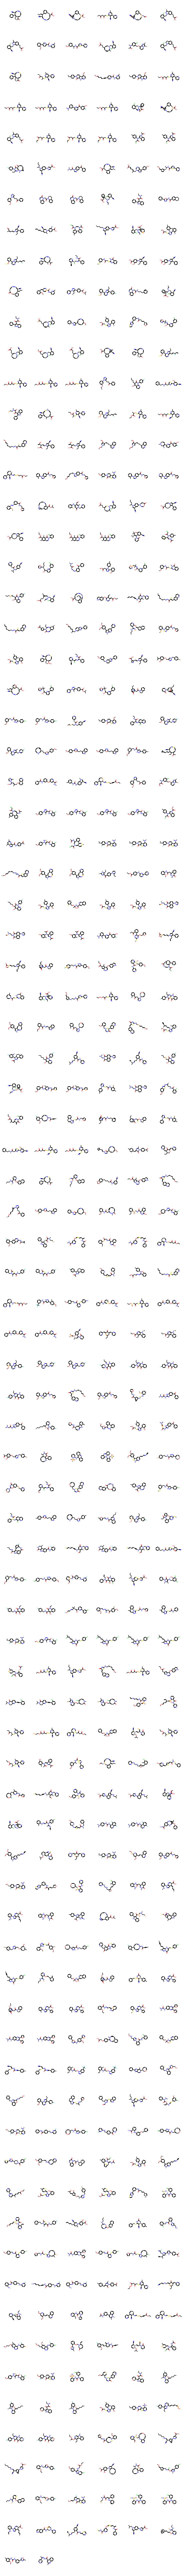

In [31]:
latest_gen_mol = [Chem.MolFromSmiles(molecule) for molecule in latest_gen["SMILES molecule"]]
img = Draw.MolsToGridImage(latest_gen_mol, 
                           molsPerRow=6, 
                           subImgSize=(150, 150), 
                           maxMols=len(latest_gen),
                           legends=None)
display(img)

In [14]:
(fn.get_smiles_list(latest_gen))

['CC1=CC=CC(=C1)C(=CN2C3=CC=CC=C3[C-1]C2=N)OC(=O)NC',
 'O=C(CN1C(=O)C=NC2=CC=CC=C21)N3CCCC4=CC=CC=C43',
 'CCC1=C(C2=CC=CC=C2)C(C#N)=CN1C3=CC=C(C(=O)O)[S+1](O)=C3',
 'CCC1=C(C2=CC=CC=C2)C(C#N)=CN1C3=CC=C(S(=O)O)C(O)=C3',
 'CO[N+1]1=CC=C(F)C=C1C2=CC=C3C=C(NC(=O)C4CC4)N=CC3=C2',
 'CCC1=C(C2=CC=CC=C2)C(C#N)=CN1C3=CC=C(C(=O)O)C(O)=C3',
 'CC(=O)NC1N=C(C2=CC=CC=C2)C(C3=CC=CC=C3)=NC1=C',
 'O=C(CN1C(=O)C=NC2=CC=CC=C21)NCCCC3=CC=CC#C3',
 'O=C([P+1]CN1C(=O)C=NC2=CC=CC=C21)N3CCCC4=CC=CC=C43',
 'CCC1=C(C2=CC=CC=C2)[P+1](C#N)=CN1C3=CC=C(C(=O)O)C(O)=C3',
 'CCC1=C(C2=CC=CC=C2)[S+1](C#N)=CN1C3=CC=C(C(=O)O)C(O)=C3',
 'CC1=CC=CC(=C1)C([P+1]N2C3=CC=CC=C3[C-1]C2=N)OC(=O)NC',
 'CCOC1=CC=CC=C1N(C(=O)N2CCC3=CC=CC=C32)C#[C+1]',
 'CC(=O)NC1=CN=C(C2=CC=CC=C2)C3=CC=CC=C3NC1=C',
 'CCC1=C(C2=CC=CC=C2)C(C#N)=CN1CC=C(C(=O)O)C(O)=C',
 'CCC1=C(C2=CC=CC=C2)C(C#N)=CN1CC=C(C(=O)O)C(O)=C',
 'C[O+1]C([S+1])CC1=NC2=CC=C(C3=CC=NN3C4=CC=C(B)C=C4)C=C2S1',
 'CCC=C(C1=CC=CC=C1)[S+1](C#N)=CN=NC2=CC=C(C(=O)I)C(O)=C2',
 'CC(=O)C[C+1

In [15]:
benzene = "c1ccccc1" 
sf.encoder(benzene)

'[C][=C][C][=C][C][=C][Ring1][=Branch1]'

<class 'list'>


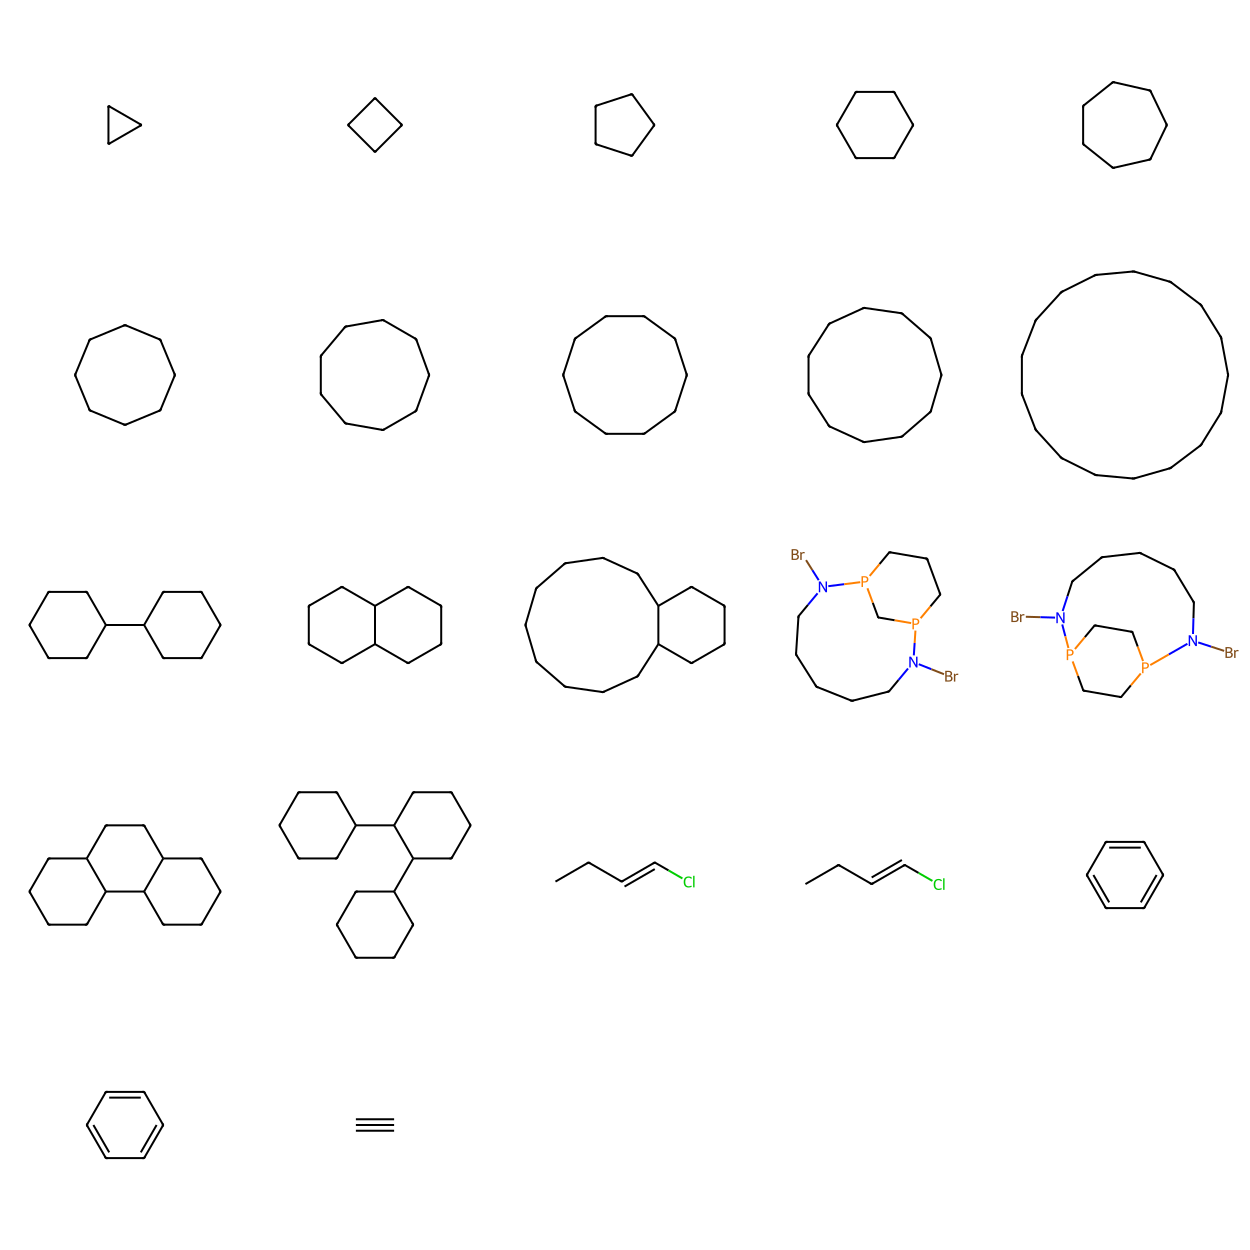

In [16]:
cycles = ["C1CC1","C1CCC1","C1CCCC1","C1CCCCC1","C1CCCCCC1",
          "C1CCCCCCC1","C1CCCCCCCC1","C1CCCCCCCCC1","C1CCCCCCCCCC1","C1CCCCCCCCCCCCCCCC1",
          "C1CCCCC1C1CCCCC1","C1C2CCCCC2CCC1","C1C2CCCCCCCCCC2CCC1", 'BrN(P1CP2CCC1)CCCCCN2Br', 'BrN(P1CCP2CC1)CCCCCN2Br',
          "C1C2C3CCCCC3CCC2CCC1","C1CCCCC1C1CCCCC1C1CCCCC1","C(=CCC)Cl","CCC=CCl","C1=CC=CC=C1",
          "C=1C=CC=CC=1","C#C"] 
cycles_mol = [Chem.MolFromSmiles(molecule) for molecule in cycles]
print(type(cycles_mol))
img = Draw.MolsToGridImage(cycles_mol, 
                           molsPerRow=5, 
                           subImgSize=(250, 250), 
                           maxMols=len(cycles_mol),
                           legends=None)
display(img)


In [17]:
for c in cycles:
    print(f"{c}\n{sf.encoder(c)}\n")

C1CC1
[C][C][C][Ring1][Ring1]

C1CCC1
[C][C][C][C][Ring1][Ring2]

C1CCCC1
[C][C][C][C][C][Ring1][Branch1]

C1CCCCC1
[C][C][C][C][C][C][Ring1][=Branch1]

C1CCCCCC1
[C][C][C][C][C][C][C][Ring1][#Branch1]

C1CCCCCCC1
[C][C][C][C][C][C][C][C][Ring1][Branch2]

C1CCCCCCCC1
[C][C][C][C][C][C][C][C][C][Ring1][=Branch2]

C1CCCCCCCCC1
[C][C][C][C][C][C][C][C][C][C][Ring1][#Branch2]

C1CCCCCCCCCC1
[C][C][C][C][C][C][C][C][C][C][C][Ring1][O]

C1CCCCCCCCCCCCCCCC1
[C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][Ring1][P]

C1CCCCC1C1CCCCC1
[C][C][C][C][C][C][Ring1][=Branch1][C][C][C][C][C][C][Ring1][=Branch1]

C1C2CCCCC2CCC1
[C][C][C][C][C][C][C][Ring1][=Branch1][C][C][C][Ring1][#Branch2]

C1C2CCCCCCCCCC2CCC1
[C][C][C][C][C][C][C][C][C][C][C][C][Ring1][O][C][C][C][Ring1][#C]

BrN(P1CP2CCC1)CCCCCN2Br
[Br][N][Branch1][=Branch2][P][C][P][C][C][C][Ring1][=Branch1][C][C][C][C][C][N][Ring1][#Branch2][Br]

BrN(P1CCP2CC1)CCCCCN2Br
[Br][N][Branch1][=Branch2][P][C][C][P][C][C][Ring1][=Branch1][C][C][C][C][

In [18]:
cycles = ["CNC(Cc1ccc2c(c1)OCO2)P",
          "CNC(C1CCCCCCCCCCCCCCCC1)P",
          "CNC(P)CC1=CC=C2C(=C1)OCO2",
          ] 


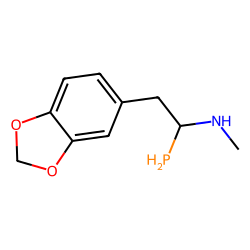

CNC(Cc1ccc2c(c1)OCO2)P
CNC(CC1=CC=C2C(=C1)OCO2)P
[C][N][C][Branch1][P][C][C][=C][C][=C][C][=Branch1][Ring2][=C][Ring1][=Branch1][O][C][O][Ring1][=Branch1][P]



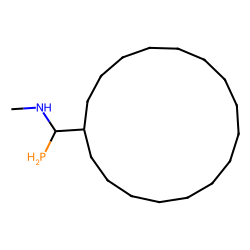

CNC(C1CCCCCCCCCCCCCCCC1)P
CNC(C1CCCCCCCCCCCCCCCC1)P
[C][N][C][Branch2][Ring1][Ring2][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][Ring1][P][P]



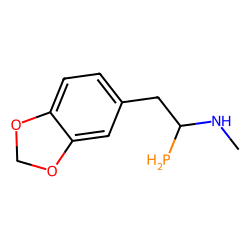

CNC(P)CC1=CC=C2C(=C1)OCO2
CNC(P)CC1=CC=C2C(=C1)OCO2
[C][N][C][Branch1][C][P][C][C][=C][C][=C][C][=Branch1][Ring2][=C][Ring1][=Branch1][O][C][O][Ring1][=Branch1]



In [19]:
def draw_annotate(chem_lst: list):
    for chem in chem_lst:
        img = Draw.MolsToGridImage([Chem.MolFromSmiles(chem)], 
                           molsPerRow=1, 
                           subImgSize=(250, 250), 
                           maxMols=len(chem_lst),
                           legends=None)
        display(img)
        print(f"{chem}\n{sf.decoder(sf.encoder(chem))}\n{sf.encoder(chem)}\n")
draw_annotate(cycles)